In [ ]:
#default_exp hasoc

In [ ]:
#export
from fastchai import config

In [ ]:
%%capture
!pip install light-the-torch
!ltt install torch torchvision
!pip install fastai==2.1.4 fastcore==1.3.2 nbdev --upgrade

#Ensure that you restart the runtime if it still shows the old version.

## Config

In [ ]:
ROOT='/content/gdrive/My Drive/Colab Notebooks/hasoc' if config.GDRIVE else './data' 
EN_DIR='en_task_a'
FILENAME='hasoc_2020_en_train_new.csv'
TEST='english_test.csv'

In [ ]:
#export
from fastai.text.all import *
from pathlib import Path

In [ ]:
assert (Path(ROOT)/'en_task_a').exists()
assert (Path(ROOT)/'en_task_a'/TEST).exists()

## Loading Data

In [ ]:
#export
def load_data(path:Path)->pd.DataFrame:
    pass

In [ ]:
df = pd.read_csv(Path(ROOT)/EN_DIR/FILENAME, sep='\t')
assert len(df) == 3708

df['tweet_id'] = df['tweet_id'].astype(str)

In [ ]:
df['is_valid'] = False

In [ ]:
df.head()

tweet_id  \
0  1.1237572634271867e+18   
1  1.1237333013977331e+18   
2  1.1237340941086595e+18   
3   1.126951188170199e+18   
4  1.1268635104477102e+18   

                                                                                                                                           text  \
0                                                    hate wen females hit ah nigga with tht bro üòÇüòÇ, I‚Äôm tryna make u my la sweety , fuck ah bro   
1                     RT @airjunebug: When you're from the Bay but you're really a NY nigga at heart. W/ @supportcaleon https://t.co/mZ8BAYlnlf   
2  RT @DonaldJTrumpJr: Dear Democrats: The American people aren‚Äôt stupid, they know what spying is and no amount of gaslighting will change th‚Ä¶   
3                        RT @SheLoveTimothy: He ain‚Äôt on drugs he just bored. I be doing the same shit when I‚Äôm bored üòÇ https://t.co/tkdjSbddET   
4  RT @TavianJordan: Summer ‚Äò19 I‚Äôm coming for you ! No boring shit ! Beach days, road trips, kickbacks and HOT DAYS ! I‚Äôm ready I‚Äôm ready I‚Äôm‚Ä¶   

  task1 task2                  ID  text_len  is_valid  
0   HOF  PRFN  hasoc_2020_en_2574        90     False  
1   HOF  PRFN  hasoc_2020_en_3627       121     False  
2   NOT  NONE  hasoc_2020_en_3108       140     False  
3   HOF  PRFN  hasoc_2020_en_3986       118     False  
4   NOT  NONE  hasoc_2020_en_5152       140     False

In [ ]:
test_df = pd.read_csv(Path(ROOT)/EN_DIR/TEST, sep=',')
test_df['is_valid'] = True
len(test_df) == 814

True

In [ ]:
test_df.head()

tweet_id  \
0  1130081762154090497   
1  1130048316807491584   
2  1123657766143504386   
3  1126782963042013186   
4  1130159113529434113   

                                                                                                                                           text  \
0           RT @delmiyaa: Samini resetting the show and moving things along as if nothing happened is all you need to know about his greatness.   
1                                                                                                      @Swxnsea how do you know that he‚Äôs left?   
2   Tried to get Divock Origi on a free seeing as he was at the club on loan. He accepted the offer, but for no actual‚Ä¶ https://t.co/3WrM7NHjwV   
3  RT @nutclusteruwu: that....is yalls stupid white ass reactions meeting tom holland in disneyland? are you fucking kidding me i would have d‚Ä¶   
4                                                                                    &amp; IT DID. But a bitch got big girls things to do now üòá   

  task1 task2                  ID  is_valid  
0   NOT  NONE  hasoc_2020_en_2713      True  
1   HOF  NONE  hasoc_2020_en_3874      True  
2   NOT  NONE   hasoc_2020_en_281      True  
3   HOF  PRFN  hasoc_2020_en_2026      True  
4   HOF  PRFN  hasoc_2020_en_4023      True

In [ ]:
all = pd.concat([df, test_df]);
len(all)
assert len(all) == 4522

In [ ]:
all['is_valid'].value_counts()

False    3708
True      814
Name: is_valid, dtype: int64

In [ ]:
list(df.columns), list(test_df.columns)

(['tweet_id', 'text', 'task1', 'task2', 'ID'],
 ['tweet_id', 'text', 'task1', 'task2', 'ID'])

In [ ]:
df['task1'].value_counts(), test_df['task1'].value_counts()

(HOF    1856
 NOT    1852
 Name: task1, dtype: int64, HOF    423
 NOT    391
 Name: task1, dtype: int64)

In [ ]:
df['task2'].value_counts(), test_df['task2'].value_counts()

(NONE    1852
 PRFN    1377
 OFFN     321
 HATE     158
 Name: task2, dtype: int64, NONE    414
 PRFN    293
 OFFN     82
 HATE     25
 Name: task2, dtype: int64)

In [ ]:
all['text_len'] = all['text'].apply(lambda x : len(x))

In [ ]:
all['text_len'].sum()/len(all)

98.47014595311809

## Language Model

In [ ]:
#export
def get_dataloaders(all:pd.DataFrame, is_lm:bool, config)->DataLoaders:
    pass

In [ ]:
dls_lm = TextDataLoaders.from_df(all, valid_pct=0.1, seed=42, text_col='text', is_lm=True, bs=128, seq_len=140)

In [ ]:
dls_lm.show_batch(max_n=1)

In [ ]:
del learn_lm

In [ ]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.02754228748381138)

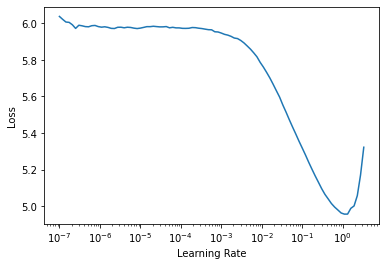

In [ ]:
learn_lm.lr_find()

In [ ]:
learn_lm.fine_tune(7, base_lr=2e-2)

In [ ]:
learn_lm.save_encoder('fine_tuned_enc')

In [ ]:
#export
from fastai.learner import Learner

def train(
        dls:DataLoaders, 
        is_lm:bool,
        config)->Learner:
    
    if is_lm:
        pass
    else:
        pass

## Task 1 Classification - Hate Speech Detection

In [ ]:
dls_cls_tsk1 = DataBlock(
    blocks=(TextBlock.from_df(text_cols='text', vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('task1'),
    splitter=ColSplitter(col='is_valid'),
).dataloaders(all, seq_len=140, bs=128)

In [ ]:
dls_cls_tsk1.show_batch(max_n=1)

In [ ]:
del learn_cls_tsk1

In [ ]:
learn_cls_tsk1 = text_classifier_learner(dls_cls_tsk1, AWD_LSTM, metrics=[accuracy, F1Score(average='macro')], loss_func=LabelSmoothingCrossEntropyFlat()).to_fp16()
learn_cls_tsk1.load_encoder('fine_tuned_enc')

In [ ]:
learn_cls_tsk1.loss_func

FlattenedLoss of LabelSmoothingCrossEntropy()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=1.5848931980144698e-06)

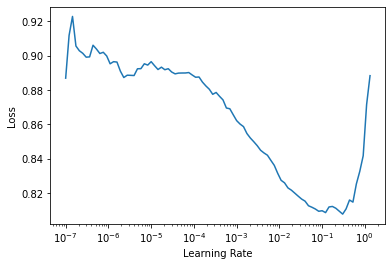

In [ ]:
learn_cls_tsk1.lr_find()

In [ ]:
learn_cls_tsk1.fine_tune(7, 3e-2) #Label Smoothing works great and also we changed the validation set to the test set

In [ ]:
#learn_cls_tsk1.fine_tune(10, 1.4e-3) #Old result not needed

In [ ]:
preds_raw, _, preds_tsk1 = learn_cls_tsk1.get_preds(dl=dls_cls_tsk1.valid, with_decoded=True)

In [ ]:
learn_cls_tsk1.dls.categorize.vocab[preds_tsk1]

(#814) ['NOT','NOT','NOT','HOF','HOF','NOT','HOF','HOF','HOF','HOF'...]

In [ ]:
submission_task1_df = test_df.drop(columns=['text', 'task1', 'task2', 'is_valid'])

In [ ]:
submission_task1_df['task1'] = learn_cls_tsk1.dls.categorize.vocab[preds_tsk1]

In [ ]:
submission_task1_df.head()

tweet_id                  ID task1
0  1130081762154090497  hasoc_2020_en_2713   NOT
1  1130048316807491584  hasoc_2020_en_3874   NOT
2  1123657766143504386   hasoc_2020_en_281   NOT
3  1126782963042013186  hasoc_2020_en_2026   HOF
4  1130159113529434113  hasoc_2020_en_4023   HOF

In [ ]:
submission_task1_df.to_csv('submission_EN_A.csv', index=False)

In [ ]:
#export
from fastai.learner import Learner
from fastai.data.all import DataLoaders

from typing import List

def predict(learn:Learner, dls:DataLoaders)->List[str]:
    pass

## Classification - Task 2

In [ ]:
dls_cls_tsk2 = DataBlock(
    blocks=(TextBlock.from_df(text_cols='text', vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('task2'),
    splitter=ColSplitter(col='is_valid')
).dataloaders(all, seq_len=140, bs=128)

In [ ]:
del learn_cls_tsk2
learn_cls_tsk2 = text_classifier_learner(dls_cls_tsk2, AWD_LSTM, metrics=[accuracy, F1Score(average='macro')], loss_func=LabelSmoothingCrossEntropyFlat()).to_fp16()
learn_cls_tsk2.load_encoder('fine_tuned_enc')

### Without Weights

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.10000000149011612)

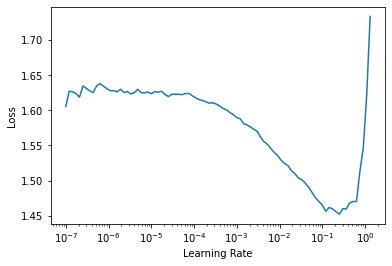

In [ ]:
learn_cls_tsk2.lr_find()

In [ ]:
learn_cls_tsk2.fine_tune(3, 2.5e-2)

In [ ]:
#learn_cls_tsk2.fine_tune(5, 1.9e-2) #Not needed anymore Old one

### With weights

In [ ]:
  def get_weights(dls):
    
      # 0th index would provide the vocab from text
      # 1st index would provide the vocab from classes
      classes = dls.vocab[1]

      #Get label ids from the dataset using map
      #train_lb_ids = L(map(lambda x: x[1], dls.train_ds))
      # Get the actual labels from the label_ids & the vocab
      #train_lbls = L(map(lambda x: classes[x], train_lb_ids))

      #Combine the above into a single
      train_lbls = L(map(lambda x: classes[x[1]], dls.train_ds))
      label_counter = Counter(train_lbls)
      n_most_common_class = max(label_counter.values()); 
      print(f'Occurrences of the most common class {n_most_common_class}')
      
      # Source: https://discuss.pytorch.org/t/what-is-the-weight-values-mean-in-torch-nn-crossentropyloss/11455/9
      weights = [1/v for k, v in label_counter.items() if v > 0]; return weights 

In [ ]:
weights = get_weights(dls_cls_tsk2)

Occurrences of the most common class 1852


In [ ]:
weights

[0.0007262164124909223,
 0.0005399568034557236,
 0.003115264797507788,
 0.006329113924050633]

In [ ]:
class_weights = torch.FloatTensor(weights).to(dls_cls_tsk2.device)

In [ ]:
learn_cls_tsk2 = text_classifier_learner(dls_cls_tsk2, AWD_LSTM, metrics=[accuracy, F1Score(average='macro')]).to_fp16()
learn_cls_tsk2.load_encoder('fine_tuned_enc')
learn_cls_tsk2.loss_func = LabelSmoothingCrossEntropyFlat(weight=class_weights)

In [ ]:
learn_cls_tsk2.loss_func

FlattenedLoss of LabelSmoothingCrossEntropy()

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.005248074419796467)

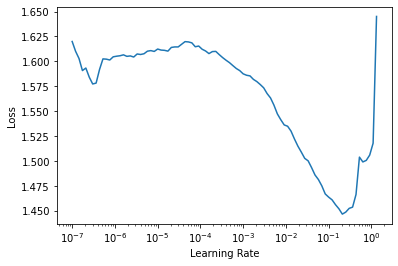

In [ ]:
learn_cls_tsk2.lr_find()

In [ ]:
learn_cls_tsk2.fine_tune(6, 5e-3)

In [ ]:
learn_cls_tsk2.validate(ds_idx=1)

(#3) [0.7849021553993225,0.8071253299713135,0.5111347519098411]

In [ ]:
interp.plot_top_losses(k=5)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_cls_tsk2)

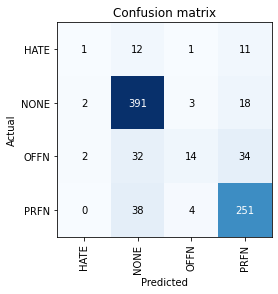

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

[('NONE', 'PRFN', 29),
 ('OFFN', 'PRFN', 14),
 ('OFFN', 'NONE', 10),
 ('HATE', 'NONE', 9),
 ('NONE', 'OFFN', 9),
 ('PRFN', 'NONE', 8),
 ('HATE', 'PRFN', 5),
 ('NONE', 'HATE', 4),
 ('PRFN', 'OFFN', 3),
 ('HATE', 'OFFN', 1),
 ('OFFN', 'HATE', 1)]

In [ ]:
learn_cls_tsk2.predict('What the fuck are you talking. go to hell')

('PRFN', tensor(3), tensor([0.0014, 0.0010, 0.0013, 0.9963]))

In [ ]:
learn_cls_tsk2.predict("I will chop off your head and kill you")

('OFFN', tensor(2), tensor([0.0061, 0.1064, 0.5032, 0.3843]))

In [ ]:
submission_task2_df = test_df.drop(columns=['text', 'task1', 'task2', 'is_valid'])

preds_raw, _, preds_tsk2 = learn_cls_tsk2.get_preds(dl=dls_cls_tsk2.valid, with_decoded=True)
submission_task2_df['task2'] = learn_cls_tsk2.dls.categorize.vocab[preds_tsk2]
submission_task2_df.to_csv('submission_EN_B.csv', index=False)